<a href="https://colab.research.google.com/github/Forger-888/1D/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NEW

In [6]:
!apt-get install -y iverilog

# PRNG module
with open("drv_pnrg.v", "w") as f:
    f.write("""module drv_pnrg (
    input clk,
    input rstn,
    input [15:0] seed,
    output reg [15:0] outnum
);
    reg [15:0] lfsr1, lfsr2, lfsr3;
    wire feedback1 = lfsr1[15] ^ lfsr1[13] ^ lfsr1[12] ^ lfsr1[10];
    wire feedback2 = lfsr2[15] ^ lfsr2[14] ^ lfsr2[11] ^ lfsr2[3];
    wire feedback3 = lfsr3[15] ^ lfsr3[12] ^ lfsr3[7] ^ lfsr3[1];

    always @(posedge clk or negedge rstn) begin
        if (!rstn) begin
            lfsr1 <= seed;
            lfsr2 <= {~seed[7:0], seed[7:0]};
            lfsr3 <= {seed[3:0], ~seed[15:4]};
        end else begin
            lfsr1 <= {lfsr1[14:0], feedback1};
            lfsr2 <= {lfsr2[14:0], feedback2};
            lfsr3 <= {lfsr3[14:0], feedback3};
        end
    end

    always @(*) begin
        outnum = lfsr1 ^ lfsr2 ^ lfsr3;
    end
endmodule
""")

# Testbench
with open("drv_pnrg_tb.v", "w") as f:
    f.write("""module drv_pnrg_tb;
    reg clk = 0;
    reg rstn;
    always #5 clk = ~clk;

    reg [15:0] seed;
    wire [15:0] outnum;
    drv_pnrg uut (.clk(clk), .rstn(rstn), .seed(seed), .outnum(outnum));

    integer i, j;
    reg [15:0] seeds[0:29];

    initial begin
        seeds[0] = 16'hACE1; seeds[1] = 16'h1234; seeds[2] = 16'h1BAD;
        seeds[3] = 16'hBEEF; seeds[4] = 16'hC0DE; seeds[5] = 16'h55AA;
        seeds[6] = 16'hF00D; seeds[7] = 16'h0C0F; seeds[8] = 16'h3EAD;
        seeds[9] = 16'h2222; seeds[10] = 16'hDEAD; seeds[11] = 16'hBABA;
        seeds[12] = 16'hAAAA; seeds[13] = 16'hFACE; seeds[14] = 16'hC0FF;
        seeds[15] = 16'hABCD; seeds[16] = 16'h9999; seeds[17] = 16'h0001;
        seeds[18] = 16'hFEED; seeds[19] = 16'h4444; seeds[20] = 16'h6969;
        seeds[21] = 16'hDEED; seeds[22] = 16'h8000; seeds[23] = 16'hFFFF;
        seeds[24] = 16'h7777; seeds[25] = 16'h5A5A; seeds[26] = 16'h1357;
        seeds[27] = 16'hF1F1; seeds[28] = 16'h2B2B; seeds[29] = 16'hCAFE;

        for (j = 0; j < 30; j = j + 1) begin
            rstn = 0; seed = seeds[j]; #20;
            rstn = 1; #20;
            for (i = 0; i < 1000; i = i + 1) begin
                #10;
                $display("%0d %0d %h", j, i, outnum);
            end
        end
        $finish;
    end
endmodule
""")

!iverilog -o sim.out drv_pnrg.v drv_pnrg_tb.v
!vvp sim.out > prng_output.txt
!head prng_output.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
iverilog is already the newest version (11.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
0 0 398e
0 1 731c
0 2 e638
0 3 cc71
0 4 98e2
0 5 31c5
0 6 638a
0 7 c715
0 8 8e2b
0 9 1c56


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm

# Parameters
num_seeds = 30
outputs_per_seed = 1000
bit_width = 9
max_val = 2 ** bit_width

value_counts = np.zeros((num_seeds, max_val), dtype=int)
bit_counts = np.zeros((num_seeds, bit_width), dtype=int)
unique_per_seed = []
csv_data = []

with open("prng_output.txt", "r") as f:
    lines = f.readlines()

for line in lines:
    parts = line.strip().split()
    if len(parts) == 3:
        seed = int(parts[0])
        val = int(parts[2], 16)
        low9 = val & 0x1FF
        value_counts[seed, low9] += 1
        for b in range(bit_width):
            if low9 & (1 << b):
                bit_counts[seed, b] += 1
        csv_data.append([seed, int(parts[1]), val])

for seed in range(num_seeds):
    unique_vals = set()
    for val, count in enumerate(value_counts[seed]):
        if count > 0:
            unique_vals.add(val)
    unique_per_seed.append(len(unique_vals))

df = pd.DataFrame(csv_data, columns=["SeedIndex", "OutputIndex", "HexValue"])
df.to_csv("prng_output.csv", index=False)


<ipython-input-8-156d351c087d>:8: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


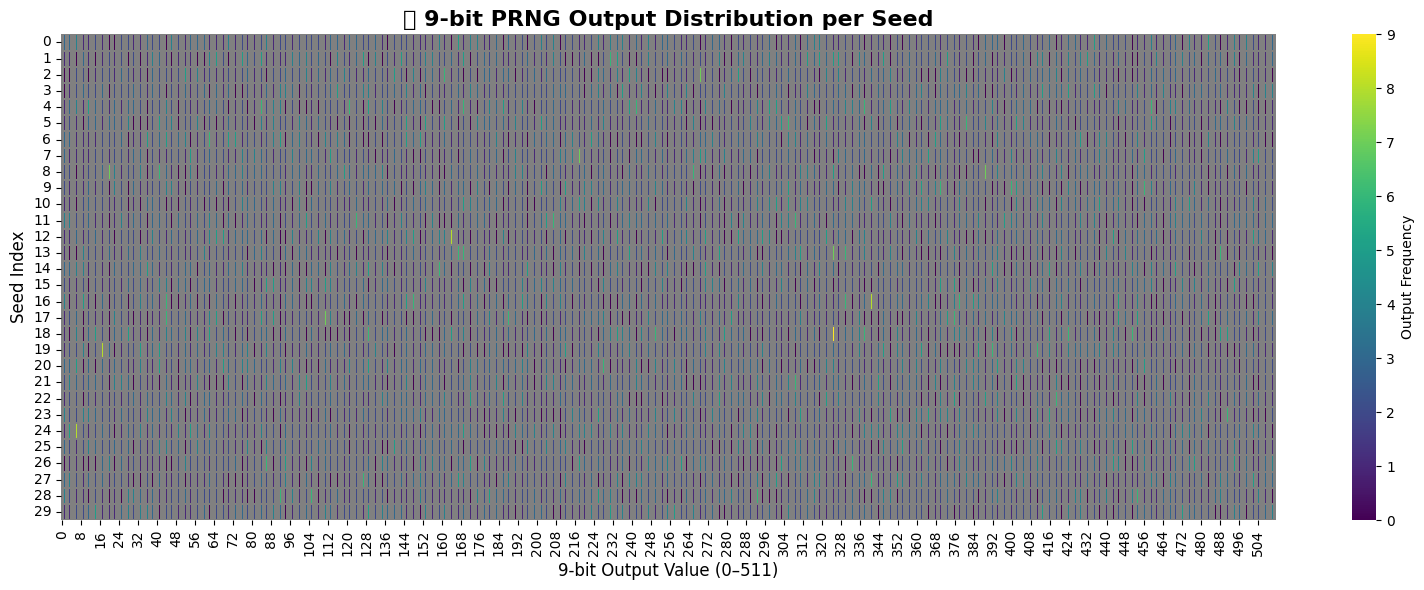

In [8]:
plt.figure(figsize=(16, 6))
sns.heatmap(value_counts, cmap="viridis", cbar_kws={"label": "Output Frequency"},
            linewidths=0.05, linecolor='gray')
plt.title("9-bit PRNG Output Distribution per Seed", fontsize=16, fontweight='bold')
plt.xlabel("9-bit Output Value (0–511)", fontsize=12)
plt.ylabel("Seed Index", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


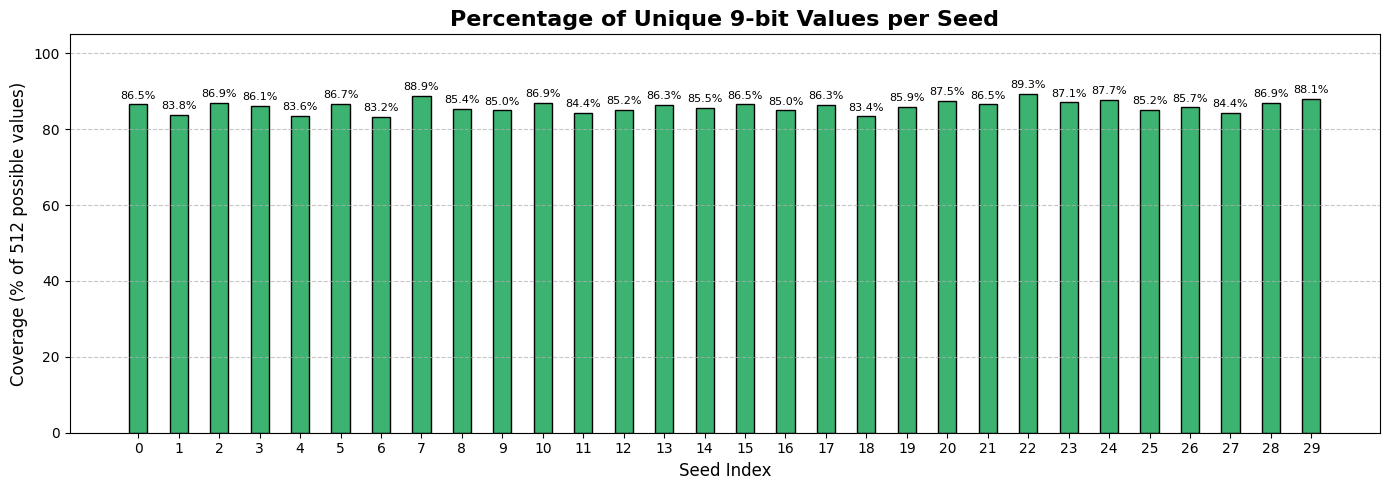

In [17]:
plt.figure(figsize=(14, 5))

# Convert counts to percentages
unique_percent = [val / 512 * 100 for val in unique_per_seed]

# Create wider spacing by increasing x positions with gaps
x = np.arange(num_seeds) * 2  # spacing factor (1.0 = default, 1.3 = spread out)
bars = plt.bar(x, unique_percent, width=0.9, color='mediumseagreen', edgecolor='black')

plt.title("Percentage of Unique 9-bit Values per Seed", fontsize=16, fontweight='bold')
plt.xlabel("Seed Index", fontsize=12)
plt.ylabel("Coverage (% of 512 possible values)", fontsize=12)
plt.ylim([0, 105])
plt.xticks(x, [str(i) for i in range(num_seeds)], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above each bar
for bar, pct in zip(bars, unique_percent):
    plt.text(bar.get_x() + bar.get_width()/2, pct + 1.5, f"{pct:.1f}%", ha='center', fontsize=8)

plt.tight_layout()
plt.show()


<ipython-input-18-f4ae68945a68>:13: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


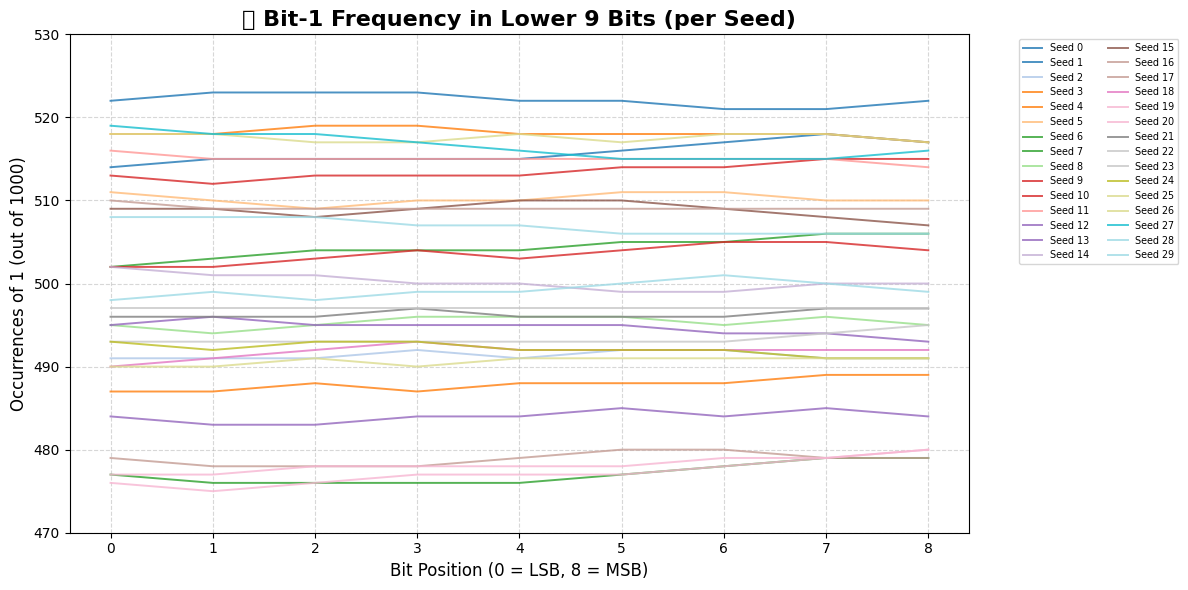

In [18]:
plt.figure(figsize=(12, 6))
colors = cm.tab20(np.linspace(0, 1, num_seeds))
for seed in range(num_seeds):
    plt.plot(range(bit_width), bit_counts[seed], label=f"Seed {seed}",
             color=colors[seed], linewidth=1.4, alpha=0.8)
plt.title("🧠 Bit-1 Frequency in Lower 9 Bits (per Seed)", fontsize=16, fontweight='bold')
plt.xlabel("Bit Position (0 = LSB, 8 = MSB)", fontsize=12)
plt.ylabel("Occurrences of 1 (out of 1000)", fontsize=12)
plt.xticks(range(bit_width))
plt.yticks(np.arange(470, 531, 10))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small', ncol=2)
plt.tight_layout()
plt.show()